In [2]:
pip install torch==1.12.1 torchvision==0.13.1

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from typing import Tuple, Dict, List
import pathlib
import os
import requests
import zipfile
from pathlib import Path
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.1+cu102
torchvision version: 0.13.1+cu102


In [5]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [6]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Check files in folders

In [28]:
data_path = Path("/notebooks/")
image_path = data_path / "Samples"
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [29]:
walk_through_dir(image_path)

There are 1 directories and 16 images in '/notebooks/Samples'.
There are 0 directories and 0 images in '/notebooks/Samples/.ipynb_checkpoints'.


In [9]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir = image_path / "val"

train_dir, val_dir, test_dir

(PosixPath('/notebooks/dataset_divided/train'),
 PosixPath('/notebooks/dataset_divided/val'),
 PosixPath('/notebooks/dataset_divided/test'))

### Visualize an image

Random image path: /notebooks/Samples/S_8.jpg
Image class: Samples
Image height: 555
Image width: 555


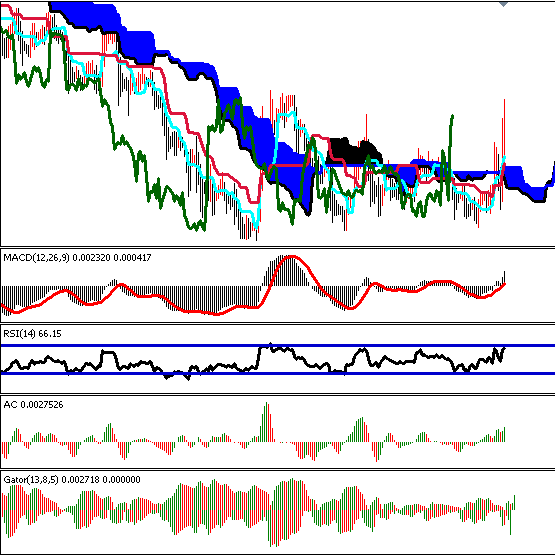

In [34]:
# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

### Visualize an image in NumPy array

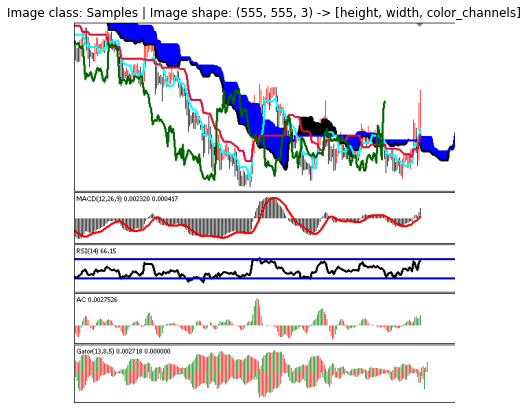

In [35]:
# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

### Transforming data with torchvision.transforms

In [36]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([    
    transforms.Resize((232, 232)), # 1. Reshape all images to 512x512 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


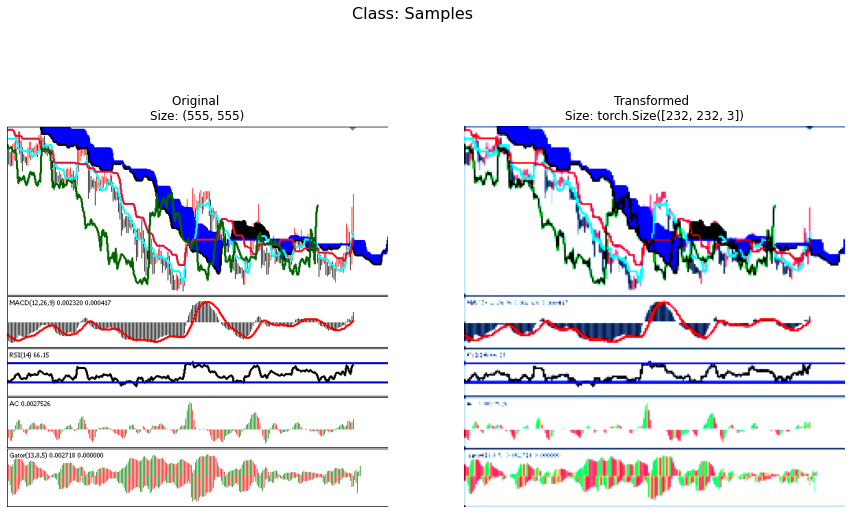

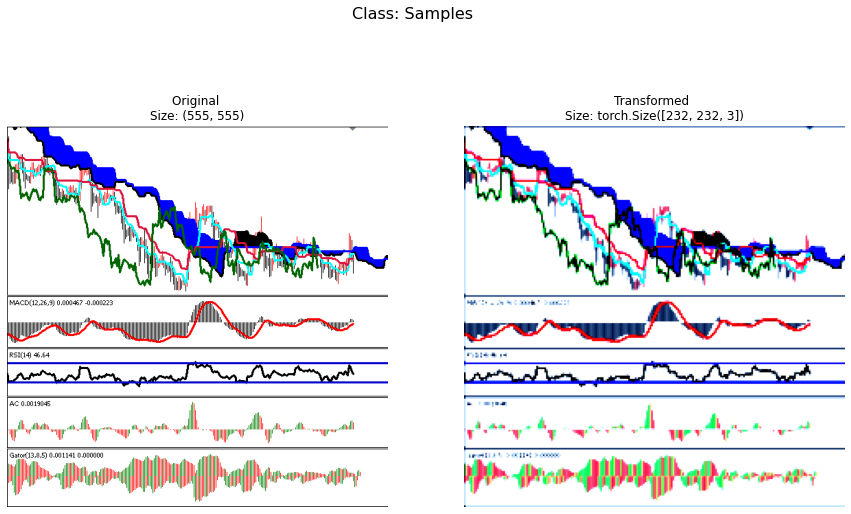

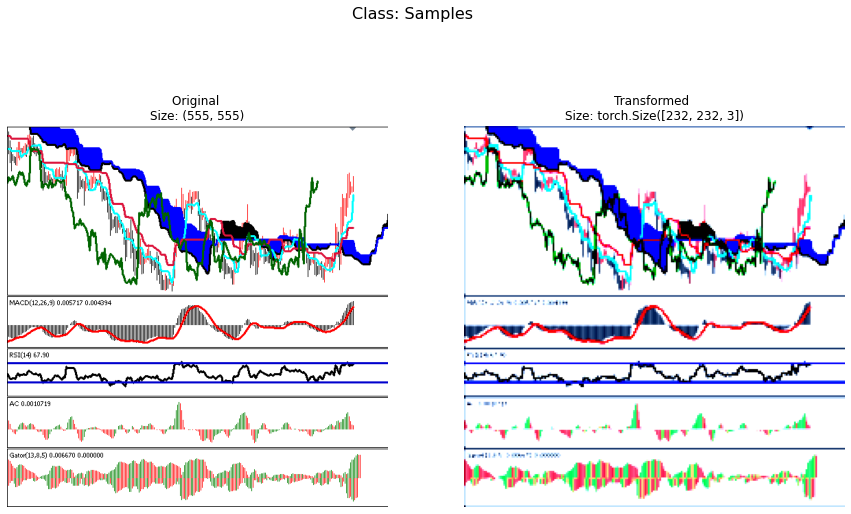

In [37]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:            
            fig, ax = plt.subplots(1, 2, figsize=(15, 9))           
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=manual_transforms, 
                        n=3)

### Loading Image Data Using ImageFolder and print inside variables

In [13]:
# Use ImageFolder to create dataset(s)
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,                                                                               
                                                                               test_dir=val_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f8ef056bf10>,
 ['0', '1', '2'])

In [14]:
# Get a set of pretrained model weights
weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2 # .DEFAULT = best available weights from pretraining on ImageNet
weights

ResNet50_Weights.IMAGENET1K_V2

In [15]:
model = torchvision.models.resnet50(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [16]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 232, 232), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 232, 232]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 232, 232]    [32, 64, 116, 116]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 116, 116]   [32, 64, 116, 116]   128                  True
├─ReLU (relu)                            [32, 64, 116, 116]   [32, 64, 116, 116]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 116, 116]   [32, 64, 58, 58]     --                   --
├─Sequential (layer1)                    [32, 64, 58, 58]     [32, 256, 58, 58]    --                   True
│    └─Bottleneck (0)                    [32, 64, 58, 58]     [32, 256, 58, 58]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 58, 58]     [32, 64, 58, 58]     4,096                True
│    │    └─BatchN

In [17]:
for params in list(model.parameters())[0:-5]:
    params.requires_grad = False

In [18]:
# # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in model.parameters():
#     param.requires_grad = False

In [17]:
# Set the manual seeds
torch.manual_seed(17)
torch.cuda.manual_seed(17)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=2048, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [18]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(17)
torch.cuda.manual_seed(17)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7394 | train_acc: 0.7275 | test_loss: 0.7258 | test_acc: 0.7272
Epoch: 2 | train_loss: 0.7146 | train_acc: 0.7287 | test_loss: 0.7073 | test_acc: 0.7286
Epoch: 3 | train_loss: 0.7073 | train_acc: 0.7289 | test_loss: 0.7504 | test_acc: 0.7164
Epoch: 4 | train_loss: 0.6967 | train_acc: 0.7293 | test_loss: 0.6996 | test_acc: 0.7287
Epoch: 5 | train_loss: 0.6774 | train_acc: 0.7319 | test_loss: 0.7028 | test_acc: 0.7285
Epoch: 6 | train_loss: 0.6379 | train_acc: 0.7427 | test_loss: 0.6868 | test_acc: 0.7200
Epoch: 7 | train_loss: 0.5691 | train_acc: 0.7680 | test_loss: 0.7536 | test_acc: 0.7402
Epoch: 8 | train_loss: 0.4779 | train_acc: 0.8075 | test_loss: 0.8525 | test_acc: 0.7477
Epoch: 9 | train_loss: 0.3808 | train_acc: 0.8473 | test_loss: 0.6791 | test_acc: 0.7616
